https://learn.astropy.org/tutorials/SpectralCubeReprojectExample.html

In [6]:
import numpy as np
from astropy.utils.data import download_file
import pandas as pd
import ipydatagrid

In [7]:
filename_1 = download_file(
    "https://almascience.eso.org/dataPortal/member.uid___A001_X1465_X3a33.BrickMaser_sci.spw71.cube.I.manual.image.pbcor.fits",
    cache=True,
)

In [8]:
filename_2 = download_file(
    "https://almascience.eso.org/dataPortal/member.uid___A001_X87d_X141.a_sma1_sci.spw27.cube.I.pbcor.fits",
    cache=True,
)

In [9]:
from spectral_cube import SpectralCube

cube1 = SpectralCube.read(filename_1)
print(cube1)

cube2 = SpectralCube.read(filename_2)
print(cube2)

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: FREQ      unit_s: Hz     range: 139434992275.503 Hz:139503942362.300 Hz
SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: FREQ      unit_s: Hz     range: 216957714464.027 Hz:217190639088.700 Hz


In [10]:
cube1.find_lines(chemical_name=" H2CS ").show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [11]:
cube2.find_lines(chemical_name="SiO").show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [12]:
from astropy import units as u

cube1vel = cube1.with_spectral_unit(
    u.km / u.s, velocity_convention="radio", rest_value=139.483699 * u.GHz
)
print(cube1vel)

cube2vel = cube2.with_spectral_unit(
    u.km / u.s, velocity_convention="radio", rest_value=217.104984 * u.GHz
)
print(cube2vel)

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s
SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: VRAD      unit_s: km / s  range:     -118.278 km / s:     203.359 km / s


D:\Deep\Projects\Learning_Astropy\.venv\Lib\site-packages\spectral_cube\spectral_cube.py:440: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


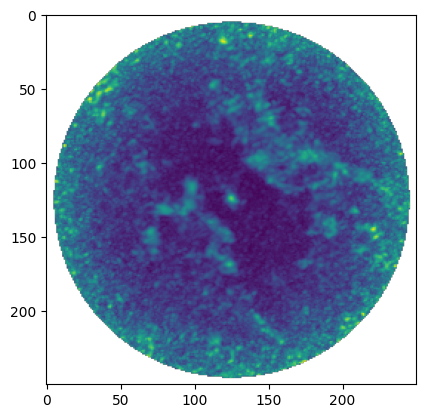

In [14]:
cube1.max(axis=0).quicklook()

D:\Deep\Projects\Learning_Astropy\.venv\Lib\site-packages\spectral_cube\spectral_cube.py:440: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


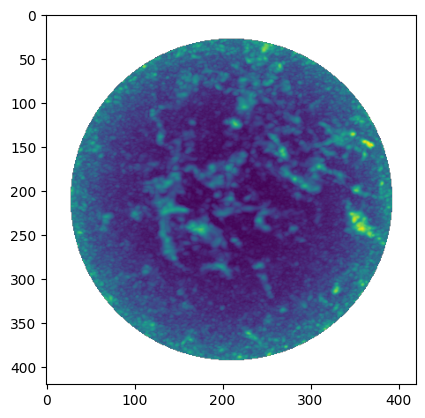

In [15]:
cube2.max(axis=0).quicklook()

In [16]:
velocity_res_1 = np.diff(cube1vel.spectral_axis)[0]
velocity_res_2 = np.diff(cube2vel.spectral_axis)[0]
velocity_res_1, velocity_res_2

(<Quantity 2.00262828 km / s>, <Quantity 0.67429189 km / s>)

In [17]:
cube2vel_cutout = cube2vel.spectral_slab(
    cube1vel.spectral_axis.min() - velocity_res_2, cube1vel.spectral_axis.max()
)
cube1vel, cube2vel_cutout

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(222, 420, 420) and unit=Jy / beam:
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    222  type_s: VRAD      unit_s: km / s  range:      -44.106 km / s:     104.913 km / s)

In [18]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2) ** 0.5
fwhm_gaussian

<Quantity 1.88569628 km / s>

In [19]:
from astropy.convolution import Gaussian1DKernel

fwhm_to_sigma = np.sqrt(8 * np.log(2))
# we want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(
    stddev=fwhm_gaussian.to(u.km / u.s).value / fwhm_to_sigma
)

In [20]:
cube2vel_smooth = cube2vel_cutout.spectral_smooth(spectral_smoothing_kernel)

In [21]:
cube2vel_spectralresample = cube2vel_smooth.spectral_interpolate(
    cube1vel.spectral_axis, suppress_smooth_warning=True
)
cube2vel_spectralresample

Spectral Interpolate: 100%|██████████| 176400/176400 [00:03<00:00, 57941.38it/s]


SpectralCube with shape=(75, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [22]:
cube1vel.beam, cube2vel_spectralresample.beam

(Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg,
 Beam: BMAJ=0.8935712308515601 arcsec BMIN=0.6649610689789199 arcsec BPA=85.81119797802 deg)

In [23]:
import radio_beam

common_beam = radio_beam.commonbeam.common_2beams(
    radio_beam.Beams(beams=[cube1vel.beam, cube2vel.beam])
)
common_beam

Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg

In [24]:
cube2vel_spatialspectralsmooth = cube2vel_spectralresample.convolve_to(common_beam)
cube2vel_spatialspectralsmooth

SpectralCube with shape=(75, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [26]:
tgthdr = cube1vel.header
tgthdr["RESTFRQ"] = cube2vel_spatialspectralsmooth.header["RESTFRQ"]

cube2vel_reproj = cube2vel_spatialspectralsmooth.reproject(tgthdr)
cube2vel_reproj

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [27]:
cube2vel_reproj, cube1vel

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s)

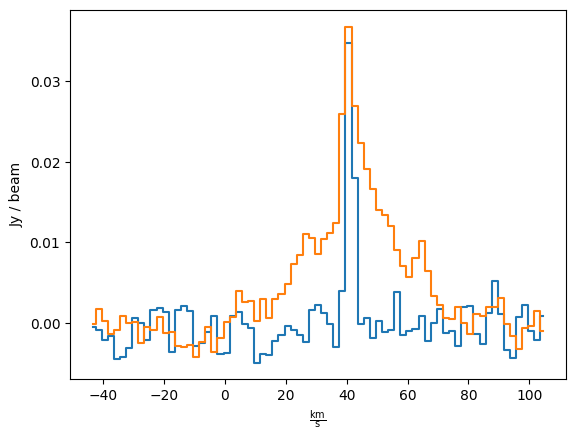

In [28]:
cube1vel[:, 125, 125].quicklook()
cube2vel_reproj[:, 125, 125].quicklook()

In [29]:
from dask.diagnostics import ProgressBar
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with ProgressBar():
        cube2dask = SpectralCube.read(filename_2, use_dask=True)
        cube2daskvel = cube2dask.with_spectral_unit(
            u.km / u.s, velocity_convention="radio", rest_value=217.104984 * u.GHz
        )
        cube2daskvel_cutout = cube2daskvel.spectral_slab(
            cube1vel.spectral_axis.min() - velocity_res_2, cube1vel.spectral_axis.max()
        )
        cube2daskvel_smooth = cube2daskvel_cutout.spectral_smooth(
            spectral_smoothing_kernel
        )
        cube2daskvel_spectralresample = cube2daskvel_smooth.spectral_interpolate(
            cube1vel.spectral_axis, suppress_smooth_warning=True
        )
        cube2daskvel_spatialspectralsmooth = cube2daskvel_spectralresample.convolve_to(
            common_beam
        )
        cube2daskvel_reproj = cube2daskvel_spatialspectralsmooth.reproject(
            tgthdr
        )  # as above, tgthdr is altered cube1vel header
cube2daskvel_reproj

[########################################] | 100% Completed | 46.71 s


DaskSpectralCube with shape=(75, 250, 250) and unit=Jy / beam and chunk size (75, 250, 250):
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

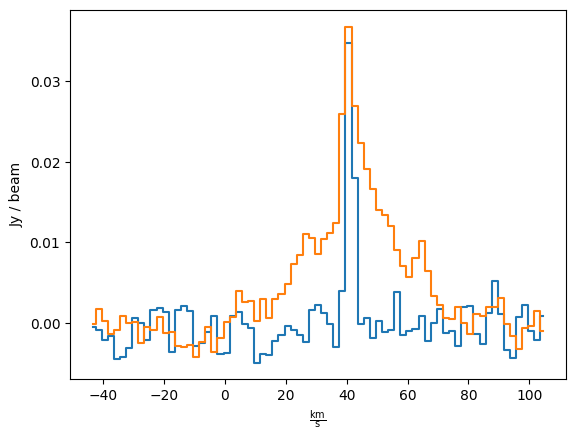

In [30]:
cube1vel[:, 125, 125].quicklook()
cube2daskvel_reproj[:, 125, 125].quicklook()